# Project Purpose:

**The goal of this project is to develop a deep learning model capable of recognizing specific voice commands (“yes” or “no”) during an ordinary conversation. The model will identify these commands with a certain level of confidence and display the results in the console.**


## About dataset:

All dataset files are located in the /data folder. The dataset consists of three categories:
- All recordings of the word “yes” are stored in /data/yes_data/
- All recordings of the word “no” are stored in /data/no_data/.
- Any other sounds, including daily conversation fragments and background noise, fall under the "unknown" category. Since these recordings may be longer than one second, they must be split into 1-second segments before training. The model will then be trained to recognize these segments as "unknown".

### Importing Modules and types:

In [32]:
### Packages:
import os
from pydub import AudioSegment
import tensorflow as tf
import gc
import numpy as np
from tensorflow.keras.layers import Rescaling, Normalization, Resizing
from tensorflow.keras import layers, models

import glob
import librosa
import soundfile as sf
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
from sklearn.metrics import roc_curve, auc, precision_recall_curve

### Typings:
from typing import Final, List, Optional
from tensorflow import Tensor
from numpy import ndarray
from tensorflow.python.types.data import DatasetV2



### Variables and functions initialization:

In [33]:


CATEGORIES: Final[List[str]] = ["yes", "no", "unknown"]
DATASET_FILE_EXTENSIONS: Final[List[str]] = [".wav", ".mp3"]
PATH_FOR_YES_DATASET: Final[str] = "data/yes_data"
PATH_FOR_NO_DATASET: Final[str] = "data/no_data"
PATH_FOR_UNPROCESSED_UNKNOWN_DATASET: Final[str] = "data/unknown_data_unprocessed"
PATH_FOR_PROCESSED_UNKNOWN_DATASET: Final[str] = "data/unknown_data_processed"
AUDIO_CLIP_LENGTH_MS: Final[int] = 1000


def check_audio_file_is_valid(file_path: str) -> (bool, Optional[AudioSegment]):
    is_file_exists: bool = os.path.exists(file_path) or os.path.isfile(file_path)

    if not is_file_exists:
        raise FileNotFoundError(f"Invalid file path, not found: {file_path}")

    file_extension = os.path.splitext(file_path)[1].lower()
    if file_extension not in DATASET_FILE_EXTENSIONS:
        raise ValueError(f"Invalid file extension: {file_path}. Expected: {DATASET_FILE_EXTENSIONS}")

    audio: AudioSegment

    if file_extension == ".wav":
        audio = AudioSegment.from_wav(file_path)
    elif file_extension == ".mp3":
        audio = AudioSegment.from_mp3(file_path)

    file_name: str = os.path.basename(file_path)
    duration: int = len(audio)

    if duration < AUDIO_CLIP_LENGTH_MS:
        raise ValueError(f"Invalid audio file duration: {duration} ms, for file {file_name}")

    return True, audio


def check_label_is_valid(label: str) -> bool:
    return label in CATEGORIES


def extract_label(file_path_tensor: Tensor) -> str:
    file_path = file_path_tensor.numpy().decode("utf-8")

    if not isinstance(file_path, str):
        raise ValueError(f"Invalid file path format: {file_path}")

    is_valid_file, _ = check_audio_file_is_valid(file_path)

    if not is_valid_file:
        raise ValueError(f"Invalid file path to extract label: {file_path}")

    full_dir_name = os.path.dirname(file_path)
    dir_name = os.path.basename(full_dir_name)
    label = dir_name.split("_")[0]

    if not check_label_is_valid(label):
        raise ValueError(f"Invalid label: {label} for file path: {file_path}")

    return label


def process_unprocessed_unknown_data(unprocessed_dataset_path: str, processed_data_set_path: str) -> None:
    counter: int = 0
    splitter_counter: int = 0
    found_file_counter: int = 0
    TARGET_SAMPLE_RATE: Final[int] = 16000

    for unprocessed_unknown_file_name in os.listdir(unprocessed_dataset_path):
        file_path = os.path.join(unprocessed_dataset_path, unprocessed_unknown_file_name)

        base_name = os.path.splitext(unprocessed_unknown_file_name)[0]
        processed_files = glob.glob(os.path.join(processed_data_set_path, f"{base_name}_part*.wav"))

        if processed_files:
            found_file_counter += 1
            print(f"Skipping {unprocessed_unknown_file_name}, already processed ({len(processed_files)} parts found).")
            continue

        is_valid_file, audio = check_audio_file_is_valid(file_path)

        if not is_valid_file or audio is None:
            raise FileNotFoundError(f"Invalid file for path: {unprocessed_unknown_file_name}")

        y, sr = librosa.load(file_path, sr=None)

        if sr != TARGET_SAMPLE_RATE:
            print(f"Resampling {unprocessed_unknown_file_name} from {sr} Hz to {TARGET_SAMPLE_RATE} Hz")
            y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SAMPLE_RATE)

        duration_ms: int = int((len(y) / TARGET_SAMPLE_RATE) * 1000)

        for i, start in enumerate(range(0, duration_ms, AUDIO_CLIP_LENGTH_MS)):
            segment_start_sample = int((start / 1000) * TARGET_SAMPLE_RATE)
            segment_end_sample = segment_start_sample + int((AUDIO_CLIP_LENGTH_MS / 1000) * TARGET_SAMPLE_RATE)

            segment = y[segment_start_sample:segment_end_sample]
            if len(segment) < int((AUDIO_CLIP_LENGTH_MS / 1000) * TARGET_SAMPLE_RATE):
                continue

            new_file_name: str = f"{base_name}_part{i}.wav"
            new_file_path: str = os.path.join(processed_data_set_path, new_file_name)

            sf.write(new_file_path, segment, TARGET_SAMPLE_RATE)

            print(f"Saved: {new_file_name}.")
            splitter_counter += 1

        counter += 1

    print(
        f"Processed {counter} new files, split into {splitter_counter} parts. Found {found_file_counter} already processed files.")


def path_to_tensor_label_map(file_path: Tensor) -> (Tensor, Tensor):
    label: Tensor = tf.py_function(func=extract_label, inp=[file_path], Tout=tf.string)

    label: Tensor = tf.reshape(label, [])

    file_tensor: Tensor = tf.io.read_file(file_path)
    audio_tensor, _ = tf.audio.decode_wav(file_tensor, desired_channels=1, desired_samples=16000)
    audio_tensor: Tensor = tf.squeeze(audio_tensor, axis=-1)

    return audio_tensor, label


def stft(waveform_par: Tensor) -> Tensor:
    spectrogram_var = tf.signal.stft(waveform_par, frame_length=256, frame_step=64, fft_length=256)
    spectrogram_var: Tensor = tf.abs(spectrogram_var)
    return spectrogram_var


def waveforms_to_spectrogram(waveform_par: Tensor, label_par: Tensor) -> (Tensor, Tensor):
    spectrogram: Tensor = stft(waveform_par)
    spectrogram_reshaped: Tensor = tf.reshape(spectrogram, (129, 247))
    spectrogram_expanded: Tensor = tf.expand_dims(spectrogram_reshaped, axis=0)
    label_ind: Tensor = tf.math.argmax(label_par == CATEGORIES)

    return spectrogram_expanded, label_ind


def convert_waveform_to_spectrogram(dataset_waveform: DatasetV2) -> DatasetV2:
    return dataset_waveform.map(waveforms_to_spectrogram)

In [34]:
## process_unprocessed_unknown_data(PATH_FOR_UNPROCESSED_UNKNOWN_DATASET, PATH_FOR_PROCESSED_UNKNOWN_DATASET)

### Path collection, shuffle and splitting data:



In [35]:

YES_LABEL_PATHS: Final[List[str]] = tf.io.gfile.glob(PATH_FOR_YES_DATASET + "/*")
NO_LABEL_PATHS: Final[List[str]] = tf.io.gfile.glob(PATH_FOR_NO_DATASET + "/*")
UNKNOWN_LABEL_PATHS: Final[List[str]] = tf.io.gfile.glob(PATH_FOR_PROCESSED_UNKNOWN_DATASET + "/*")

YES_LABEL_PATHS_SHUFFLED: Final[List[str]] = tf.random.shuffle(YES_LABEL_PATHS)
NO_LABEL_PATHS_SHUFFLED: Final[List[str]] = tf.random.shuffle(NO_LABEL_PATHS)
UNKNOWN_LABEL_PATHS_SHUFFLED: Final[List[str]] = tf.random.shuffle(UNKNOWN_LABEL_PATHS)

YES_LABEL_DATASET_PIPELINE: DatasetV2 = tf.data.Dataset.from_tensor_slices(YES_LABEL_PATHS_SHUFFLED)
NO_LABEL_DATASET_PIPELINE: DatasetV2 = tf.data.Dataset.from_tensor_slices(NO_LABEL_PATHS_SHUFFLED)
UNKNOWN_LABEL_DATASET_PIPELINE: DatasetV2 = tf.data.Dataset.from_tensor_slices(UNKNOWN_LABEL_PATHS_SHUFFLED)

YES_LABELED_DATASET_LABEL_MAPPED: DatasetV2 = YES_LABEL_DATASET_PIPELINE.map(path_to_tensor_label_map)
NO_LABELED_DATASET_LABEL_MAPPED: DatasetV2 = NO_LABEL_DATASET_PIPELINE.map(path_to_tensor_label_map)
UNKNOWN_LABELED_DATASET_LABEL_MAPPED: DatasetV2 = UNKNOWN_LABEL_DATASET_PIPELINE.map(path_to_tensor_label_map)

TRAIN_RATIO: Final[float] = 0.6
TEST_RATIO: Final[float] = 0.2
VALIDATION_RATIO: Final[float] = 0.2

SAMPLE_SIZE_FOR_EACH_CLASS: Final[int] = min(len(YES_LABEL_PATHS), len(NO_LABEL_PATHS), len(UNKNOWN_LABEL_PATHS))

TRAIN_SIZE: Final[int] = int(TRAIN_RATIO * SAMPLE_SIZE_FOR_EACH_CLASS)
TEST_SIZE: Final[int] = int(TEST_RATIO * SAMPLE_SIZE_FOR_EACH_CLASS)
VALIDATION_SIZE: Final[int] = int(VALIDATION_RATIO * SAMPLE_SIZE_FOR_EACH_CLASS)

TRAIN_DATASET_FOR_YES_LABEL_IN_WAVEFORM: DatasetV2 = YES_LABELED_DATASET_LABEL_MAPPED.take(TRAIN_SIZE)
TRAIN_DATASET_FOR_NO_LABEL_IN_WAVEFORM: DatasetV2 = NO_LABELED_DATASET_LABEL_MAPPED.take(TRAIN_SIZE)
TRAIN_DATASET_FOR_UNKNOWN_LABEL_IN_WAVEFORM: DatasetV2 = UNKNOWN_LABELED_DATASET_LABEL_MAPPED.take(TRAIN_SIZE)

REMAINING_YES = YES_LABELED_DATASET_LABEL_MAPPED.skip(TRAIN_SIZE)
REMAINING_NO = NO_LABELED_DATASET_LABEL_MAPPED.skip(TRAIN_SIZE)
REMAINING_UNKNOWN = UNKNOWN_LABELED_DATASET_LABEL_MAPPED.skip(TRAIN_SIZE)

TEST_DATASET_FOR_YES_LABEL_IN_WAVEFORM: DatasetV2 = REMAINING_YES.take(TEST_SIZE)
TEST_DATASET_FOR_NO_LABEL_IN_WAVEFORM: DatasetV2 = REMAINING_NO.take(TEST_SIZE)
TEST_DATASET_FOR_UNKNOWN_LABEL_IN_WAVEFORM: DatasetV2 = REMAINING_UNKNOWN.take(TEST_SIZE)

REMAINING_YES = REMAINING_YES.skip(TEST_SIZE)
REMAINING_NO = REMAINING_NO.skip(TEST_SIZE)
REMAINING_UNKNOWN = REMAINING_UNKNOWN.skip(TEST_SIZE)

VALIDATION_DATASET_FOR_YES_LABEL_IN_WAVEFORM: DatasetV2 = REMAINING_YES.take(VALIDATION_SIZE)
VALIDATION_DATASET_FOR_NO_LABEL_IN_WAVEFORM: DatasetV2 = REMAINING_NO.take(VALIDATION_SIZE)
VALIDATION_DATASET_FOR_UNKNOWN_LABEL_IN_WAVEFORM: DatasetV2 = REMAINING_UNKNOWN.take(VALIDATION_SIZE)

TRAIN_DATASET_FOR_YES_LABEL_IN_SPEC = convert_waveform_to_spectrogram(TRAIN_DATASET_FOR_YES_LABEL_IN_WAVEFORM)
TRAIN_DATASET_FOR_NO_LABEL_IN_SPEC = convert_waveform_to_spectrogram(TRAIN_DATASET_FOR_NO_LABEL_IN_WAVEFORM)
TRAIN_DATASET_FOR_UNKNOWN_LABEL_IN_SPEC = convert_waveform_to_spectrogram(TRAIN_DATASET_FOR_UNKNOWN_LABEL_IN_WAVEFORM)

TEST_DATASET_FOR_YES_LABEL_IN_SPEC = convert_waveform_to_spectrogram(TEST_DATASET_FOR_YES_LABEL_IN_WAVEFORM)
TEST_DATASET_FOR_NO_LABEL_IN_SPEC = convert_waveform_to_spectrogram(TEST_DATASET_FOR_NO_LABEL_IN_WAVEFORM)
TEST_DATASET_FOR_UNKNOWN_LABEL_IN_SPEC = convert_waveform_to_spectrogram(TEST_DATASET_FOR_UNKNOWN_LABEL_IN_WAVEFORM)

VALIDATION_DATASET_FOR_YES_LABEL_IN_SPEC = convert_waveform_to_spectrogram(VALIDATION_DATASET_FOR_YES_LABEL_IN_WAVEFORM)
VALIDATION_DATASET_FOR_NO_LABEL_IN_SPEC = convert_waveform_to_spectrogram(VALIDATION_DATASET_FOR_NO_LABEL_IN_WAVEFORM)
VALIDATION_DATASET_FOR_UNKNOWN_LABEL_IN_SPEC = convert_waveform_to_spectrogram(
    VALIDATION_DATASET_FOR_UNKNOWN_LABEL_IN_WAVEFORM)

TRAIN_DATASET = TRAIN_DATASET_FOR_YES_LABEL_IN_SPEC.concatenate(TRAIN_DATASET_FOR_NO_LABEL_IN_SPEC).concatenate(
    TRAIN_DATASET_FOR_UNKNOWN_LABEL_IN_SPEC).shuffle(1000)
TEST_DATASET = TEST_DATASET_FOR_YES_LABEL_IN_SPEC.concatenate(TEST_DATASET_FOR_NO_LABEL_IN_SPEC).concatenate(
    TEST_DATASET_FOR_UNKNOWN_LABEL_IN_SPEC).shuffle(1000)
VALIDATION_DATASET = VALIDATION_DATASET_FOR_YES_LABEL_IN_SPEC.concatenate(
    VALIDATION_DATASET_FOR_NO_LABEL_IN_SPEC).concatenate(VALIDATION_DATASET_FOR_UNKNOWN_LABEL_IN_SPEC).shuffle(1000)

del TRAIN_SIZE, TEST_SIZE, VALIDATION_SIZE

del YES_LABEL_PATHS, NO_LABEL_PATHS, UNKNOWN_LABEL_PATHS
del YES_LABEL_PATHS_SHUFFLED, NO_LABEL_PATHS_SHUFFLED, UNKNOWN_LABEL_PATHS_SHUFFLED

del YES_LABEL_DATASET_PIPELINE, NO_LABEL_DATASET_PIPELINE, UNKNOWN_LABEL_DATASET_PIPELINE
del YES_LABELED_DATASET_LABEL_MAPPED, NO_LABELED_DATASET_LABEL_MAPPED, UNKNOWN_LABELED_DATASET_LABEL_MAPPED

del TRAIN_DATASET_FOR_YES_LABEL_IN_WAVEFORM, TRAIN_DATASET_FOR_NO_LABEL_IN_WAVEFORM, TRAIN_DATASET_FOR_UNKNOWN_LABEL_IN_WAVEFORM
del TEST_DATASET_FOR_YES_LABEL_IN_WAVEFORM, TEST_DATASET_FOR_NO_LABEL_IN_WAVEFORM, TEST_DATASET_FOR_UNKNOWN_LABEL_IN_WAVEFORM
del VALIDATION_DATASET_FOR_YES_LABEL_IN_WAVEFORM, VALIDATION_DATASET_FOR_NO_LABEL_IN_WAVEFORM, VALIDATION_DATASET_FOR_UNKNOWN_LABEL_IN_WAVEFORM
gc.collect()

SHAPE_OF_FEATURES = TRAIN_DATASET.element_spec[0].shape


def check_dataset_distribution(dataset, dataset_name):
    label_counts = Counter()

    for _, label in dataset.as_numpy_iterator():
        label_counts[label] += 1

    print(f"Distribution for class {dataset_name}:", label_counts)


check_dataset_distribution(TRAIN_DATASET, "Train")
check_dataset_distribution(TEST_DATASET, "Test")
check_dataset_distribution(VALIDATION_DATASET, "Validation")

print(SHAPE_OF_FEATURES)



Distribution for class Train: Counter({np.int64(0): 1200, np.int64(1): 1200, np.int64(2): 1200})
Distribution for class Test: Counter({np.int64(0): 400, np.int64(1): 400, np.int64(2): 400})
Distribution for class Validation: Counter({np.int64(1): 400, np.int64(0): 400, np.int64(2): 400})
(1, 129, 247)


### Batching:

In [37]:
BATCH_SIZE = 32

TRAIN_DATASET_BATCH = TRAIN_DATASET.map(
    lambda spec, label: (tf.squeeze(tf.expand_dims(spec, axis=0), axis=1), label)
).batch(BATCH_SIZE)

VALIDATION_DATASET_BATCH = VALIDATION_DATASET.map(
    lambda spec, label: (tf.squeeze(tf.expand_dims(spec, axis=0), axis=1), label)
).batch(BATCH_SIZE)

for spec_train, label_train in TRAIN_DATASET_BATCH.take(1):
    print(f"Shape of spectrogram: {spec_train.shape}")
    print(f"Shape of label: {label_train.shape}")
    print(f"Label: {spec_train}")

for sample_train, label_train in TRAIN_DATASET_BATCH.take(1):
    print("Example sample shape", sample_train.shape)
    print("Label:", label_train.numpy())

Shape of spectrogram: (32, 1, 129, 247)
Shape of label: (32,)
Label: [[[[3.6372060e-03 1.4984535e-02 1.8859843e-02 ... 2.8484568e-04
    2.6390239e-04 2.7540021e-04]
   [2.9186273e-04 3.9269472e-04 3.2701602e-04 ... 3.8154155e-04
    6.8996823e-04 7.9400023e-04]
   [3.7033754e-04 9.0530678e-04 9.0653310e-04 ... 1.5110029e-03
    6.0928660e-04 1.1563622e-03]
   ...
   [9.9766895e-04 2.2456006e-03 2.9667225e-03 ... 2.6381954e-03
    3.4401100e-03 6.9328225e-03]
   [3.7484432e-03 8.1361942e-03 9.0006553e-03 ... 1.6468646e-02
    2.3190219e-02 2.8848020e-02]
   [2.6435860e-02 8.3600627e-03 1.4002785e-02 ... 3.7172391e-05
    1.8163575e-05 3.6537182e-05]]]


 [[[1.4869446e-01 1.1293005e-01 7.7263504e-02 ... 3.6685329e-03
    2.1930528e-03 5.8975187e-04]
   [5.3106440e-04 4.1298560e-04 3.6002813e-05 ... 8.0198003e-03
    5.9013632e-03 2.6146031e-03]
   [4.3817651e-03 8.1815710e-03 9.5523996e-03 ... 2.4421134e-03
    3.9020050e-03 4.9823271e-03]
   ...
   [3.6935019e-03 3.5309389e-03 4.460597

### Inspecting the data

In [28]:
"""
import matplotlib.pyplot as plt

waveforms = []
labels = []

for audio, label in TRAIN_DATASET_FOR_YES_LABEL_IN_WAVEFORM.as_numpy_iterator():
    waveforms.append(audio)
    labels.append(label.decode())

# Plot waveforms
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15, 20))
axes = axes.flatten()

for i, (waveform, label) in enumerate(zip(waveforms, labels)):
    if i >= len(axes):
        break

    axes[i].plot(waveform)
    axes[i].set_title(f"Sample {i} - Label: {label}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

"""

'\nimport matplotlib.pyplot as plt\n\nwaveforms = []\nlabels = []\n\nfor audio, label in TRAIN_DATASET_FOR_YES_LABEL_IN_WAVEFORM.as_numpy_iterator():\n    waveforms.append(audio)\n    labels.append(label.decode())\n\n# Plot waveforms\nfig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15, 20))\naxes = axes.flatten()\n\nfor i, (waveform, label) in enumerate(zip(waveforms, labels)):\n    if i >= len(axes):\n        break\n\n    axes[i].plot(waveform)\n    axes[i].set_title(f"Sample {i} - Label: {label}")\n    axes[i].set_xlabel("Time")\n    axes[i].set_ylabel("Amplitude")\n\nplt.tight_layout()\nplt.show()\n\n'

### Building Model:

In [38]:
norm_layer = Normalization()

norm_layer.adapt(TRAIN_DATASET_BATCH.map(lambda spec, label: spec))

model = models.Sequential()

model.add(layers.Input(shape=SHAPE_OF_FEATURES))
model.add(layers.Resizing(32, 32))
model.add(norm_layer)

model.add(layers.Conv2D(32, 3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
model.add(layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(CATEGORIES), activation='softmax'))

model.summary()

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

print("Model Input Shape:", model.input_shape)
print("Model Output Shape:", model.output_shape)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)           │ (None, 32, 32, 247)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 32, 32, 247)    │           495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,994 (1.51 MB)

 Trainable params: 394,051 (1.50 MB)

 Non-trainable params: 943 (3.69 KB)

Model Input Shape: (None, 1, 129, 247)
Model Output Shape: (None, 3)


### Compilation:

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [40]:
history = model.fit(TRAIN_DATASET_BATCH, validation_data=VALIDATION_DATASET_BATCH, epochs=30,
                    callbacks=[early_stopping, lr_callback])


113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 242ms/step - accuracy: 0.8044 - loss: 0.5781 - val_accuracy: 0.8008 - val_loss: 0.6389 - learning_rate: 0.0010
Epoch 9/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 230ms/step - accuracy: 0.8300 - loss: 0.4958 - val_accuracy: 0.8167 - val_loss: 0.6247 - learning_rate: 0.0010
Epoch 10/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 237ms/step - accuracy: 0.8366 - loss: 0.4759 - val_accuracy: 0.8458 - val_loss: 0.5295 - learning_rate: 0.0010
Epoch 11/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 238ms/step - accuracy: 0.8644 - loss: 0.4115 - val_accuracy: 0.8383 - val_loss: 0.6203 - learning_rate: 0.0010
Epoch 12/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 245ms/step - accuracy: 0.8788 - loss: 0.3767 - val_accuracy: 0.7867 - val_loss: 0.8638 - learning_rate: 0.0010
Epoch 13/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 245ms/step - accuracy: 0.8768 - loss: 0.3869 - val_accuracy: 0.8492 - val_loss: 0.6018 - learning_rate: 0.0010
Epoch 14/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.9055 - 

Result: accuracy: 0.9670 - loss: 0.0981 - val_accuracy: 0.9217 - val_loss: 0.5295 - learning_rate: 5.0000e-04


### Manuel Testing Preparation

In [41]:
test_spec_arr = []
test_label_arr = []

for spectrogram_val, label in TEST_DATASET.as_numpy_iterator():
    test_spec_arr.append(spectrogram_val)
    test_label_arr.append(label)

test_spec_arr = np.array(test_spec_arr)
test_label_arr = np.array(test_label_arr)


### Manuel Testing:

In [46]:

ith_sample: int = 190
count_of_samples: int = len(test_spec_arr)

model_prediction = model.predict(test_spec_arr)[ith_sample]
actual_label = test_label_arr[ith_sample]
probabilities = softmax(model_prediction)

formatted_probabilities = [f"{prob:.5f}" for prob in probabilities]

print("Categories:", CATEGORIES)
print(f"Model Prediction {ith_sample + 1}'th of {count_of_samples}", model_prediction)
print("Probabilities:", formatted_probabilities)
print("Predicted Label:", CATEGORIES[np.argmax(probabilities)])
print("Actual Label:", CATEGORIES[actual_label])


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
Categories: ['yes', 'no', 'unknown']
Model Prediction 191'th of 1200 [1.5666656e-05 1.2146515e-06 9.9998319e-01]
Probabilities: ['0.21195', '0.21194', '0.57611']
Predicted Label: unknown
Actual Label: unknown


### Average Testing Results:

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Accuracy: 0.9067 (90.67%)


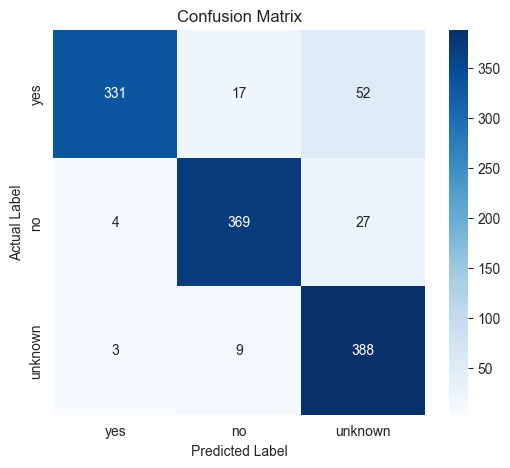


Classification Report:
               precision    recall  f1-score   support

         yes       0.98      0.83      0.90       400
          no       0.93      0.92      0.93       400
     unknown       0.83      0.97      0.90       400

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



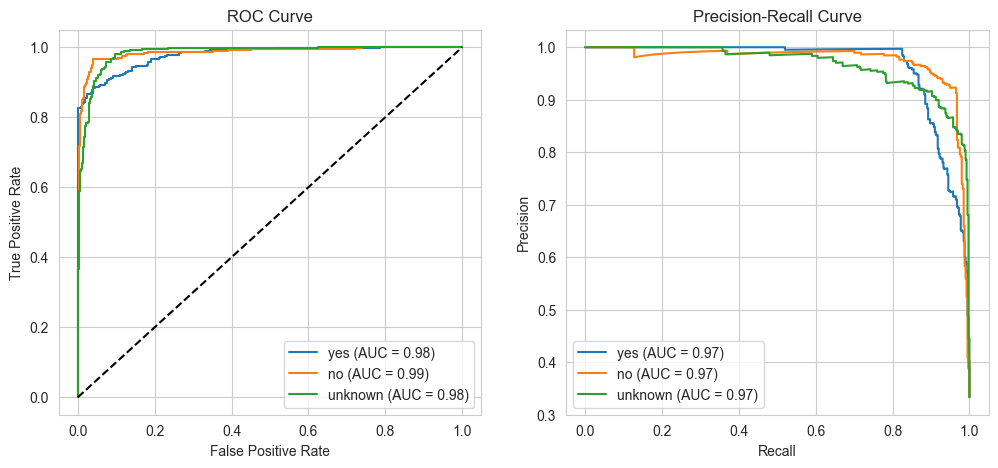

In [47]:
test_spec_arr = []
test_label_arr = []

for spectrogram_val, label in TEST_DATASET.as_numpy_iterator():
    test_spec_arr.append(spectrogram_val)
    test_label_arr.append(label)

test_spec_arr = np.array(test_spec_arr)
test_label_arr = np.array(test_label_arr)

model_predictions = model.predict(test_spec_arr)

probabilities: ndarray = softmax(model_predictions, axis=1)

predicted_labels: int = np.argmax(probabilities, axis=1)

accuracy: float = accuracy_score(test_label_arr, predicted_labels)
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

conf_matrix: ndarray = confusion_matrix(test_label_arr, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(test_label_arr, predicted_labels, target_names=CATEGORIES))

test_label_bin = label_binarize(test_label_arr, classes=[0, 1, 2])
fpr, tpr, roc_auc = {}, {}, {}

precision, recall, pr_auc = {}, {}, {}

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, category in enumerate(CATEGORIES):
    fpr[i], tpr[i], _ = roc_curve(test_label_bin[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{category} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
for i, category in enumerate(CATEGORIES):
    precision[i], recall[i], _ = precision_recall_curve(test_label_bin[:, i], probabilities[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i], label=f"{category} (AUC = {pr_auc[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.show()


### Model Saving:

In [48]:
model.save("models/model_0.keras");

In [53]:
import json

mean = norm_layer.mean.numpy().tolist()
stddev = (norm_layer.variance.numpy() ** 0.5).tolist()

with open("normalization_values.json", "w") as f:
    json.dump({"mean": mean, "stddev": stddev}, f)
